In [1]:
#################################################################
# 0. Libraries

import pandas as pd
import numpy as np
import os
import glob
import kaggle

from tqdm import tqdm
from sklearn.preprocessing import normalize

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import albumentations
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2
from functools import partial

physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

from tensorflow.keras import models, layers, regularizers, metrics, losses, optimizers, constraints
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score

np.random.seed(12)

#################################################################

In [2]:
#################################################################
# 1. Global Variables & Paths

PATH = '../01_Data/'
PATH_MODELS = '../03_Models/'

df_labels = pd.read_csv(PATH + 'train_labels.csv')
df_sample_sub = pd.read_csv(PATH + 'sample_submission.csv')
print(df_labels['target'].value_counts()/len(df_labels))

list_paths_train = glob.glob(PATH + 'train/' + '*/*.npy')
list_paths_test = glob.glob(PATH + 'test/' + '*/*.npy')

dict_paths_train = {path.split('\\')[-1].split('.npy')[0] : path for path in list_paths_train}
dict_paths_test = {path.split('\\')[-1].split('.npy')[0] : path for path in list_paths_test}

df_labels['path'] = df_labels['id'].apply(lambda x : dict_paths_train[x])
df_sample_sub['path'] = df_sample_sub['id'].apply(lambda x : dict_paths_test[x])

list_records = df_labels[['id', 'target']].to_dict('records')
dict_paths_labels_train = {elem['id'] : elem['target'] for elem in list_records}

IMG_SIZE = (340, 340, 1)

pos, neg = len(df_labels[df_labels['target']==1]), len(df_labels[df_labels['target']==0])

assert df_sample_sub.isna().sum().sum() == 0
assert df_labels.isna().sum().sum() == 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
df_labels["fold"] = -1
for fold_id, (_, val_idx) in enumerate(skf.split(df_labels["id"], df_labels["target"])):
    df_labels.loc[val_idx, "fold"] = fold_id

#################################################################

0    0.906429
1    0.093571
Name: target, dtype: float64


In [3]:
#################################################################
# 2. Functions

def plotCadence(file_id):
    label = df_labels['target'][df_labels['id']==os.path.basename(file_id).split('.')[0]].values[0]
    img = np.load(file_id).astype(np.float32)
    plt.figure(figsize=(16, 10))
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"ID: {os.path.basename(file_id)} TARGET: {label}", fontsize=18)
        plt.imshow(img[i], interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
    plt.show()
# '../01_Data/train\\b\\bd31565fc0f0.npy'
#################################################################

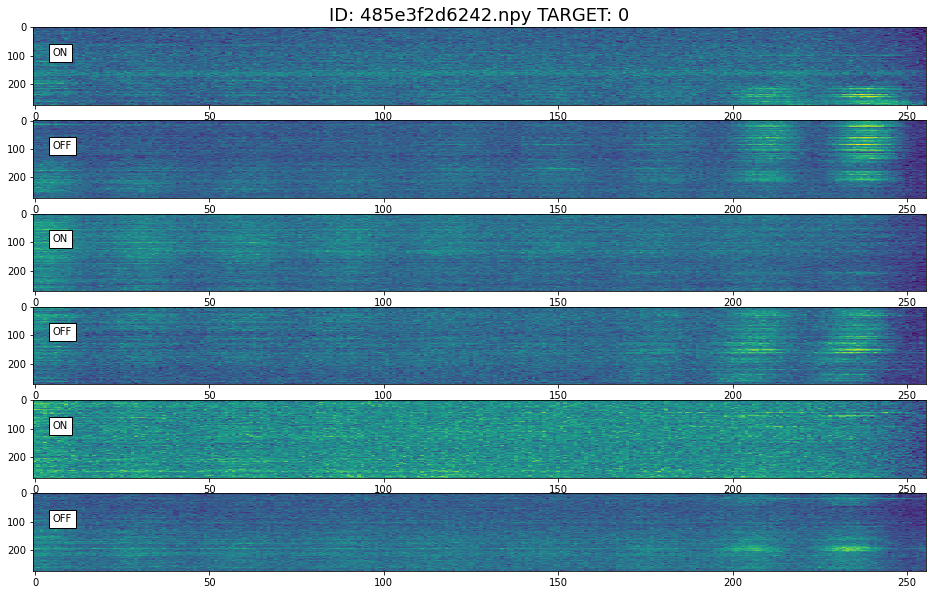

In [4]:
idx = np.random.choice(list_paths_train)
plotCadence(idx)

In [5]:
#################################################################
# 3. Data Loader

def normalize_ft(x):
    x = (x - np.mean(x, axis=0, keepdims=True)) / np.std(x, axis=0, keepdims=True)
    x = (x - np.mean(x, axis=0, keepdims=True)) / np.std(x, axis=0, keepdims=True)
    return x

def fake_needle(img):
    # signal shape
    x = int(np.random.uniform(50, 250))
    y = int(np.random.uniform(0, 819))
    ax_x = int(np.random.uniform(15, 30)) 
    ax_y = int(np.random.uniform(500, 650)) 
    angle = np.random.uniform(-5, -1.5) 
    start_angle = np.random.uniform(115, 130) 
    end_angle = np.random.uniform(220, 235)
    color = np.random.uniform(0.8, 2.5)
    
    # signal_value
    signal_value = np.random.uniform(1.5, 4)
    
    signal = np.full((819, 256), 0, dtype=np.uint8)
    signal = cv2.ellipse(signal, (x, y), (ax_x, ax_y), angle, start_angle, end_angle, color, thickness=1)
    signal = np.where(signal > 0, signal_value, signal)
    
    augmentation_img = img + signal
    return augmentation_img

def spec_augment(x, alpha=0.05):
    t0 = np.random.randint(0, x.shape[0])
    delta = np.random.randint(0, int(x.shape[0]*alpha))
    x[t0:min(t0+delta, x.shape[0])] = 0
    t0 = np.random.randint(0, x.shape[1])
    delta = np.random.randint(0, int(x.shape[1]*alpha))
    x[:, t0:min(t0+delta, x.shape[1])] = 0
    return x

class SpecAugment(ImageOnlyTransform):
    def apply(self, img, **params):
        return spec_augment(img)
    
class FakeNeedle(ImageOnlyTransform):
    def apply(self, img, **params):
        return fake_needle(img)

def getTrainTransforms():
    list_transforms = albumentations.Compose([
        FakeNeedle(p=0.4),
        albumentations.HorizontalFlip(p=0.4),
        albumentations.VerticalFlip(p=0.4),
        albumentations.ShiftScaleRotate(shift_limit=0.1, rotate_limit=0, p=0.4),
        albumentations.Cutout(num_holes=12, max_h_size=20, max_w_size=20, p=0.4),
        SpecAugment(p=0.4),
        albumentations.MotionBlur(p=0.4)
    ])
    return list_transforms

def getTestTransforms():
    list_transforms = albumentations.Compose([
        # albumentations.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1)
    ])
    return list_transforms


def buildMixUp(batch_size, p=1.0):
    def mixup(image, label): 
        label = tf.cast(label, tf.float32)
        imgs = []; labs = []
        for j in range(batch_size):
            # DO MIXUP WITH PROBABILITY DEFINED ABOVE
            P = tf.cast( tf.random.uniform([],0,1)<=p, tf.float32)
            # CHOOSE RANDOM
            k = tf.cast( tf.random.uniform([],0,batch_size),tf.int32)
            a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
            # MAKE MIXUP IMAGE
            img1 = image[j,]
            img2 = image[k,]
            imgs.append((1-a)*img1 + a*img2)
            # MAKE CUTMIX LABEL

            lab1 = label[j,]
            lab2 = label[k,]
            labs.append((1-a)*lab1 + a*lab2)

        # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
        image2 = tf.reshape(tf.stack(imgs),(batch_size, IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
        label2 = tf.reshape(tf.stack(labs),(batch_size, 1))
        return image2, label2
    return mixup


def read_npy_file(list_transforms, img_path):
    img_on = np.vstack(np.load(img_path.decode())[::2]).astype(np.float32)
    img_on = normalize_ft(img_on)
    # img_off = np.vstack(np.load(img_path.decode())[[1, 3, 5]]).astype(np.float32)
    img = img_on.copy()#normalize(img_on - img_off)
    data = {"image":img}
    img = list_transforms(**data)
    img = img["image"]
    img = np.expand_dims(img, -1)
    img = tf.image.resize(img, size=[IMG_SIZE[0], IMG_SIZE[1]])
    return tf.cast(img, tf.float32)

def set_shapes(img, label):
    img.set_shape(IMG_SIZE)
    if label is not None:
        label.set_shape([])
    return img, label


def build_dataset(paths, labels=None, bsize=32, list_transforms=None, shuffle=True, p_mixup=0.3):
    mixup_builder = buildMixUp(bsize, p=p_mixup)
    AUTO = tf.data.AUTOTUNE
    slices = (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    if shuffle:
        dset = dset.shuffle(len(labels))
        
    dset = dset.map(lambda x, y: (tf.numpy_function(partial(read_npy_file, list_transforms), [x], [tf.float32])[0], y), num_parallel_calls=AUTO)
    dset = dset.map(set_shapes, num_parallel_calls=AUTO)
    if p_mixup>0.0:
        dset = dset.batch(bsize, drop_remainder=True).prefetch(AUTO)
        dset = dset.map(mixup_builder, num_parallel_calls=AUTO)
    else:
        dset = dset.batch(bsize, drop_remainder=False).prefetch(AUTO)
    return dset   
            

#################################################################

  0%|                                                                                            | 0/1 [00:01<?, ?it/s]

(32, 340, 340, 1) (32, 1)
tf.Tensor([0.], shape=(1,), dtype=float32)


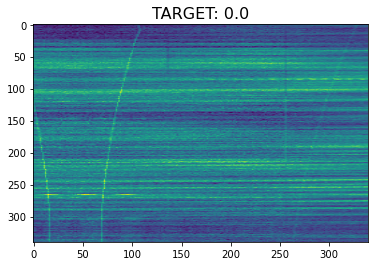

In [6]:
list_paths = list(dict_paths_train.values())[:34]
list_labels = [dict_paths_labels_train[x.split('\\')[-1].split('.npy')[0]] for x in list_paths]
dataset_train = build_dataset(list_paths, labels=list_labels, bsize=32, list_transforms=getTrainTransforms(), shuffle=False, p_mixup=0.75)
for batch in tqdm(dataset_train):
    data, target = batch
    # print(np.mean(target))
    break

data, target = batch

print(data.shape, target.shape)
print(target[1])
plt.imshow(data[1], interpolation='nearest', aspect='auto')
plt.title(f"TARGET: {target[1].numpy()[0]}", fontsize=16)
plt.show();

In [7]:
# img_on = np.vstack(np.load(list_paths[20])[::2]).astype(np.float32)
# img_off = np.vstack(np.load(list_paths[20])[[1, 3, 5]]).astype(np.float32)
# print(img_on.shape, img_off.shape)
# plt.imshow(img_on, interpolation='nearest', aspect='auto')
# plt.show();
# plt.imshow(img_off, interpolation='nearest', aspect='auto')
# plt.show();
# plt.imshow(img_on - img_off, interpolation='nearest', aspect='auto')
# plt.show();
# plt.imshow(normalize(img_on - img_off), interpolation='nearest', aspect='auto')
# plt.show();

In [8]:
#################################################################
# 4. Model

class BaseEncoderImgs(models.Model):
    def __init__(self):
        super(BaseEncoderImgs, self).__init__()
        self.backbone_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                                include_top=False, weights='imagenet')
        self.backbone_model.trainable = True
        self.base_model = tf.keras.Model(self.backbone_model.input, 
                                         self.backbone_model.layers[-1].output)

        self.cnn_ini = models.Sequential([
            layers.Conv2D(3, 3, padding='same', strides=1 ,activation='relu')
        ])
        
    def call(self, img_input, training):
        x = tf.nn.relu(self.cnn_ini(img_input))
        x = self.base_model(x, training)
        return x
    
    
class Model(models.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.img_encoder = BaseEncoderImgs()
        ###
        self.avg_glob_pool = layers.GlobalAveragePooling2D()
        self.fc_final = models.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5)
        ])
        self.final_layer = layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=True):
        x = self.img_encoder(inputs, training=training)
        x = self.avg_glob_pool(x)
        x = self.fc_final(x, training)
        prob = self.final_layer(x)
        
        return prob
    
def getModel():
    return Model()


class ReturnBestEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)
            
            
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.cast(tf.math.minimum(arg1, arg2), tf.float32)

#################################################################

Text(0.5, 0, 'Train Step')

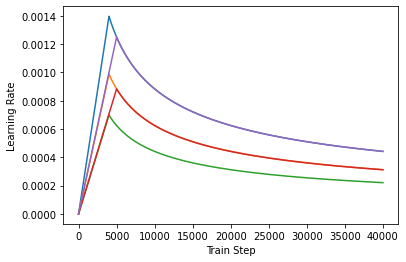

In [9]:
temp_learning_rate_schedule = CustomSchedule(128)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(256)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(256, 5_000)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(128, 5_000)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [10]:
#################################################################
# 5. Training

tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

batch_size = 32
val_size = 0.05
early_stop = ReturnBestEarlyStopping(monitor='val_auc', mode="max", patience=10, verbose=1, restore_best_weights=True)
model_base_name = 'model_v0.9'
load_model = (False, 'model_v0.6')


for fold in range(1, 5):
    print('==='*30)
    print(f'Fold: {fold}')
    print('==='*30)
    
    list_imgs_t = list(df_labels['id'][df_labels['fold']!=fold].values)
    list_imgs_val = list(df_labels['id'][df_labels['fold']==fold].values)
    
    print(f'Train images: {len(list_imgs_t)}, Val images: {len(list_imgs_val)}')
    
    list_paths_t, list_labels_t = [dict_paths_train[x] for x in list_imgs_t],  [dict_paths_labels_train[x] for x in list_imgs_t]
    list_paths_val, list_labels_val = [dict_paths_train[x] for x in list_imgs_val],  [dict_paths_labels_train[x] for x in list_imgs_val]
    
    train_data_generator = build_dataset(list_paths_t, labels=list_labels_t, bsize=batch_size, list_transforms=getTrainTransforms(), shuffle=True, p_mixup=0.75)
    val_data_generator = build_dataset(list_paths_val, labels=list_labels_val, bsize=batch_size, list_transforms=getTestTransforms(), shuffle=True, p_mixup=0.0)

    # Model
    if load_model[0]:
        print(f'Tranining new model loading ckpt from {load_model[1]} ...')
        model = models.load_model(f'{PATH_MODELS + load_model[1]}/{load_model[1]}_fold_{fold}')
    else:
        print(f'Tranining full new model ...')
        model = getModel()
        
    learning_rate = CustomSchedule(256, 5_000)
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(optimizers.Adam(learning_rate)), 
                  loss=losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(name='acc'), metrics.AUC(name='auc'),
                           metrics.Precision(name='precission'), metrics.Recall(name='recall'), metrics.AUC(name='prc', curve='PR')])

    class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(df_labels['target']),
                                                df_labels['target'])
    class_weights = dict(enumerate(class_weights))

    history = model.fit(train_data_generator,
                        validation_data=val_data_generator,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        epochs=40,
                        verbose=1)
    
    if not os.path.exists(PATH_MODELS + model_base_name):
        os.mkdir(PATH_MODELS + model_base_name)
        
    model.save(f'{PATH_MODELS + model_base_name}/{model_base_name}_fold_{fold}', include_optimizer=False)
    model.save_weights(f'{PATH_MODELS + model_base_name}/{model_base_name}_fold_{fold}_weights', save_format='tf')

# fold0 - 0.9834
#################################################################

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
Fold: 1
Train images: 40132, Val images: 10033
Tranining full new model ...
Epoch 1/40
1254/1254 [==============================] - 346s 224ms/step - loss: 0.2770 - acc: 0.8436 - auc: 0.6837 - precission: 0.7137 - recall: 0.1424 - prc: 0.3870 - val_loss: 0.1256 - val_acc: 0.9625 - val_auc: 0.9362 - val_precission: 0.9812 - val_recall: 0.6113 - val_prc: 0.8504
Epoch 2/40
1254/1254 [==============================] - 277s 220ms/step - loss: 0.2124 - acc: 0.8562 - auc: 0.7831 - precission: 0.9027 - recall: 0.3131 - prc: 0.6035 - val_loss: 0.2218 - val_acc: 0.9403 - val_auc: 0.7982 - val_precission: 0.9885 - val_recall: 0.3663 - val_prc: 0.6573
Epoch 3/40
1254/1254 [==============================] - 278s 222ms/step - loss: 0.2039 - acc: 0.8569 - auc: 0.8

In [11]:
# ==========================================================================================
# Fold: 0
# ==========================================================================================
# Train images: 40132, Val images: 10033
# Tranining full new model ...
# Epoch 1/35
# 1255/1255 [==============================] - 395s 295ms/step - loss: 0.2312 - acc: 0.9004 - auc: 0.7909 - precission: 0.8219 - recall: 0.3209 - prc: 0.5345 - val_loss: 0.1049 - val_acc: 0.9729 - val_auc: 0.9456 - val_precission: 0.9359 - val_recall: 0.7623 - val_prc: 0.8705
# Epoch 2/35
# 1255/1255 [==============================] - 359s 286ms/step - loss: 0.1710 - acc: 0.9189 - auc: 0.8571 - precission: 0.8974 - recall: 0.5151 - prc: 0.7071 - val_loss: 0.1839 - val_acc: 0.9247 - val_auc: 0.9463 - val_precission: 0.5631 - val_recall: 0.8699 - val_prc: 0.8750
# Epoch 3/35
# 1255/1255 [==============================] - 399s 318ms/step - loss: 0.1710 - acc: 0.9204 - auc: 0.8588 - precission: 0.9017 - recall: 0.5265 - prc: 0.7148 - val_loss: 0.1058 - val_acc: 0.9745 - val_auc: 0.9530 - val_precission: 0.9749 - val_recall: 0.7463 - val_prc: 0.8860
# Epoch 4/35
# 1255/1255 [==============================] - 387s 309ms/step - loss: 0.1673 - acc: 0.9195 - auc: 0.8647 - precission: 0.9020 - recall: 0.5305 - prc: 0.7241 - val_loss: 0.1638 - val_acc: 0.9457 - val_auc: 0.9254 - val_precission: 0.8066 - val_recall: 0.5512 - val_prc: 0.7434
# Epoch 5/35
# 1255/1255 [==============================] - 445s 354ms/step - loss: 0.1500 - acc: 0.9256 - auc: 0.8791 - precission: 0.9289 - recall: 0.5966 - prc: 0.7667 - val_loss: 0.0883 - val_acc: 0.9784 - val_auc: 0.9568 - val_precission: 0.9712 - val_recall: 0.7921 - val_prc: 0.9036
# Epoch 6/35
# 1255/1255 [==============================] - 393s 313ms/step - loss: 0.1384 - acc: 0.9297 - auc: 0.8924 - precission: 0.9428 - recall: 0.6311 - prc: 0.7944 - val_loss: 0.1171 - val_acc: 0.9700 - val_auc: 0.9456 - val_precission: 0.9747 - val_recall: 0.6972 - val_prc: 0.8768
# Epoch 7/35
# 1255/1255 [==============================] - 359s 286ms/step - loss: 0.1383 - acc: 0.9307 - auc: 0.8911 - precission: 0.9493 - recall: 0.6325 - prc: 0.7913 - val_loss: 0.0838 - val_acc: 0.9802 - val_auc: 0.9710 - val_precission: 0.9843 - val_recall: 0.8006 - val_prc: 0.9292
# Epoch 8/35
# 1255/1255 [==============================] - 383s 305ms/step - loss: 0.1337 - acc: 0.9316 - auc: 0.8958 - precission: 0.9543 - recall: 0.6481 - prc: 0.8014 - val_loss: 0.0762 - val_acc: 0.9843 - val_auc: 0.9781 - val_precission: 0.9577 - val_recall: 0.8699 - val_prc: 0.9427
# Epoch 9/35
# 1255/1255 [==============================] - 358s 285ms/step - loss: 0.1290 - acc: 0.9313 - auc: 0.9045 - precission: 0.9549 - recall: 0.6532 - prc: 0.8164 - val_loss: 0.0798 - val_acc: 0.9800 - val_auc: 0.9760 - val_precission: 1.0000 - val_recall: 0.7857 - val_prc: 0.9441
# Epoch 10/35
# 1255/1255 [==============================] - 377s 301ms/step - loss: 0.1234 - acc: 0.9338 - auc: 0.9087 - precission: 0.9630 - recall: 0.6605 - prc: 0.8176 - val_loss: 0.0673 - val_acc: 0.9838 - val_auc: 0.9747 - val_precission: 0.9974 - val_recall: 0.8284 - val_prc: 0.9398
# Epoch 11/35
# 1255/1255 [==============================] - 366s 292ms/step - loss: 0.1217 - acc: 0.9342 - auc: 0.9147 - precission: 0.9698 - recall: 0.6784 - prc: 0.8321 - val_loss: 0.0645 - val_acc: 0.9855 - val_auc: 0.9776 - val_precission: 0.9938 - val_recall: 0.8507 - val_prc: 0.9490
# Epoch 12/35
# 1255/1255 [==============================] - 369s 294ms/step - loss: 0.1185 - acc: 0.9341 - auc: 0.9129 - precission: 0.9678 - recall: 0.6728 - prc: 0.8267 - val_loss: 0.0724 - val_acc: 0.9851 - val_auc: 0.9802 - val_precission: 0.9925 - val_recall: 0.8475 - val_prc: 0.9498
# Epoch 13/35
# 1255/1255 [==============================] - 412s 328ms/step - loss: 0.1213 - acc: 0.9328 - auc: 0.9100 - precission: 0.9690 - recall: 0.6671 - prc: 0.8284 - val_loss: 0.0507 - val_acc: 0.9891 - val_auc: 0.9834 - val_precission: 0.9952 - val_recall: 0.8881 - val_prc: 0.9603
# Epoch 14/35
# 1255/1255 [==============================] - 353s 281ms/step - loss: 0.1143 - acc: 0.9356 - auc: 0.9151 - precission: 0.9731 - recall: 0.6760 - prc: 0.8356 - val_loss: 0.0529 - val_acc: 0.9879 - val_auc: 0.9821 - val_precission: 0.9857 - val_recall: 0.8838 - val_prc: 0.9555
# Epoch 15/35
# 1255/1255 [==============================] - 381s 303ms/step - loss: 0.1131 - acc: 0.9353 - auc: 0.9185 - precission: 0.9653 - recall: 0.6886 - prc: 0.8415 - val_loss: 0.0531 - val_acc: 0.9861 - val_auc: 0.9827 - val_precission: 0.9376 - val_recall: 0.9126 - val_prc: 0.9572
# Epoch 16/35
# 1255/1255 [==============================] - 353s 281ms/step - loss: 0.1107 - acc: 0.9355 - auc: 0.9192 - precission: 0.9749 - recall: 0.6923 - prc: 0.8482 - val_loss: 0.0544 - val_acc: 0.9891 - val_auc: 0.9802 - val_precission: 0.9825 - val_recall: 0.8998 - val_prc: 0.9546
# Epoch 17/35
# 1255/1255 [==============================] - 376s 299ms/step - loss: 0.1093 - acc: 0.9369 - auc: 0.9238 - precission: 0.9756 - recall: 0.6918 - prc: 0.8484 - val_loss: 0.0531 - val_acc: 0.9880 - val_auc: 0.9825 - val_precission: 0.9928 - val_recall: 0.8785 - val_prc: 0.9565
# Epoch 18/35
# 1255/1255 [==============================] - 359s 286ms/step - loss: 0.1072 - acc: 0.9374 - auc: 0.9221 - precission: 0.9768 - recall: 0.6950 - prc: 0.8471 - val_loss: 0.0541 - val_acc: 0.9891 - val_auc: 0.9821 - val_precission: 0.9964 - val_recall: 0.8870 - val_prc: 0.9576
# Epoch 19/35
# 1255/1255 [==============================] - 372s 296ms/step - loss: 0.1070 - acc: 0.9371 - auc: 0.9284 - precission: 0.9763 - recall: 0.6937 - prc: 0.8560 - val_loss: 0.0485 - val_acc: 0.9899 - val_auc: 0.9837 - val_precission: 0.9772 - val_recall: 0.9136 - val_prc: 0.9587
# Epoch 20/35
# 1255/1255 [==============================] - 351s 279ms/step - loss: 0.1057 - acc: 0.9361 - auc: 0.9265 - precission: 0.9765 - recall: 0.6860 - prc: 0.8541 - val_loss: 0.0532 - val_acc: 0.9874 - val_auc: 0.9814 - val_precission: 0.9856 - val_recall: 0.8785 - val_prc: 0.9549
# Epoch 21/35
# 1255/1255 [==============================] - 366s 292ms/step - loss: 0.1031 - acc: 0.9385 - auc: 0.9280 - precission: 0.9788 - recall: 0.6846 - prc: 0.8523 - val_loss: 0.0481 - val_acc: 0.9894 - val_auc: 0.9826 - val_precission: 0.9837 - val_recall: 0.9019 - val_prc: 0.9587
# Epoch 22/35
# 1255/1255 [==============================] - 348s 278ms/step - loss: 0.1038 - acc: 0.9386 - auc: 0.9285 - precission: 0.9784 - recall: 0.6963 - prc: 0.8543 - val_loss: 0.0482 - val_acc: 0.9893 - val_auc: 0.9800 - val_precission: 0.9964 - val_recall: 0.8891 - val_prc: 0.9580
# Epoch 23/35
# 1255/1255 [==============================] - 369s 294ms/step - loss: 0.1019 - acc: 0.9371 - auc: 0.9251 - precission: 0.9786 - recall: 0.6989 - prc: 0.8571 - val_loss: 0.0516 - val_acc: 0.9898 - val_auc: 0.9837 - val_precission: 0.9941 - val_recall: 0.8966 - val_prc: 0.9624
# Epoch 24/35
# 1255/1255 [==============================] - 350s 279ms/step - loss: 0.1003 - acc: 0.9364 - auc: 0.9287 - precission: 0.9788 - recall: 0.6963 - prc: 0.8578 - val_loss: 0.0527 - val_acc: 0.9879 - val_auc: 0.9802 - val_precission: 0.9723 - val_recall: 0.8966 - val_prc: 0.9511
# Epoch 25/35
# 1255/1255 [==============================] - 374s 298ms/step - loss: 0.1026 - acc: 0.9373 - auc: 0.9327 - precission: 0.9778 - recall: 0.7123 - prc: 0.8632 - val_loss: 0.0463 - val_acc: 0.9903 - val_auc: 0.9821 - val_precission: 0.9976 - val_recall: 0.8987 - val_prc: 0.9606
# Epoch 26/35
# 1255/1255 [==============================] - 354s 282ms/step - loss: 0.0968 - acc: 0.9413 - auc: 0.9390 - precission: 0.9799 - recall: 0.7216 - prc: 0.8729 - val_loss: 0.0500 - val_acc: 0.9877 - val_auc: 0.9830 - val_precission: 0.9744 - val_recall: 0.8923 - val_prc: 0.9557
# Epoch 27/35
# 1255/1255 [==============================] - 371s 295ms/step - loss: 0.0968 - acc: 0.9393 - auc: 0.9325 - precission: 0.9793 - recall: 0.7114 - prc: 0.8650 - val_loss: 0.0463 - val_acc: 0.9891 - val_auc: 0.9834 - val_precission: 0.9882 - val_recall: 0.8945 - val_prc: 0.9616
# Epoch 28/35
# 1255/1255 [==============================] - 349s 278ms/step - loss: 0.0951 - acc: 0.9410 - auc: 0.9319 - precission: 0.9845 - recall: 0.7150 - prc: 0.8647 - val_loss: 0.0513 - val_acc: 0.9900 - val_auc: 0.9800 - val_precission: 0.9941 - val_recall: 0.8987 - val_prc: 0.9596
# Epoch 29/35
# 1255/1255 [==============================] - 373s 297ms/step - loss: 0.0942 - acc: 0.9414 - auc: 0.9356 - precission: 0.9841 - recall: 0.7130 - prc: 0.8684 - val_loss: 0.0436 - val_acc: 0.9907 - val_auc: 0.9851 - val_precission: 0.9976 - val_recall: 0.9030 - val_prc: 0.9630
# Epoch 30/35
# 1255/1255 [==============================] - 361s 287ms/step - loss: 0.0960 - acc: 0.9403 - auc: 0.9361 - precission: 0.9818 - recall: 0.7115 - prc: 0.8703 - val_loss: 0.0453 - val_acc: 0.9902 - val_auc: 0.9831 - val_precission: 0.9965 - val_recall: 0.8987 - val_prc: 0.9635
# Epoch 31/35
# 1255/1255 [==============================] - 372s 297ms/step - loss: 0.0929 - acc: 0.9405 - auc: 0.9352 - precission: 0.9861 - recall: 0.7075 - prc: 0.8694 - val_loss: 0.0448 - val_acc: 0.9902 - val_auc: 0.9825 - val_precission: 0.9988 - val_recall: 0.8966 - val_prc: 0.9607
# Epoch 32/35
# 1255/1255 [==============================] - 355s 282ms/step - loss: 0.0956 - acc: 0.9408 - auc: 0.9376 - precission: 0.9820 - recall: 0.7095 - prc: 0.8718 - val_loss: 0.0563 - val_acc: 0.9875 - val_auc: 0.9778 - val_precission: 0.9988 - val_recall: 0.8678 - val_prc: 0.9554
# Epoch 33/35
# 1255/1255 [==============================] - 365s 291ms/step - loss: 0.0923 - acc: 0.9403 - auc: 0.9362 - precission: 0.9850 - recall: 0.7092 - prc: 0.8722 - val_loss: 0.0516 - val_acc: 0.9882 - val_auc: 0.9827 - val_precission: 0.9976 - val_recall: 0.8763 - val_prc: 0.9608
# Epoch 34/35
# 1255/1255 [==============================] - 349s 278ms/step - loss: 0.0972 - acc: 0.9377 - auc: 0.9379 - precission: 0.9833 - recall: 0.6989 - prc: 0.8752 - val_loss: 0.0445 - val_acc: 0.9907 - val_auc: 0.9820 - val_precission: 0.9896 - val_recall: 0.9104 - val_prc: 0.9609
# Epoch 35/35
# 1255/1255 [==============================] - 364s 290ms/step - loss: 0.0945 - acc: 0.9386 - auc: 0.9382 - precission: 0.9812 - recall: 0.7070 - prc: 0.8717 - val_loss: 0.0410 - val_acc: 0.9908 - val_auc: 0.9846 - val_precission: 0.9873 - val_recall: 0.9136 - val_prc: 0.9655

In [12]:
#################################################################
# 6. Validation

def auc_group(df):
    y_pred = df.preds
    y_true = df.target
    return roc_auc_score(y_true, np.where(y_pred>0.5, 1, 0))

model_base_name = 'model_v0.9'

df_val_preds = pd.DataFrame()
for fold in range(5):
    print('==='*30)
    print(f'Fold: {fold}')
    print('==='*30)
    
    list_imgs_val = list(df_labels['id'][df_labels['fold']==fold].values)

    list_paths_val, list_labels_val = [dict_paths_train[x] for x in list_imgs_val],  [dict_paths_labels_train[x] for x in list_imgs_val]
    val_data_generator = build_dataset(list_paths_val, labels=list_labels_val, bsize=batch_size, list_transforms=getTestTransforms(), shuffle=False, p_mixup=0.0)
    
    model = models.load_model(PATH_MODELS + model_base_name + '/' + model_base_name + f'_fold_{fold}')
    preds = model.predict(val_data_generator, verbose=1)
    
    df_tmp = pd.DataFrame({
        'id' : list_imgs_val,
        'fold' : fold,
        'preds' : preds.squeeze(-1) 
    })
    
    df_tmp = pd.merge(df_tmp, df_labels[['id', 'target']], how='inner', on='id')
    df_val_preds = pd.concat([df_val_preds, df_tmp], axis=0).reset_index(drop=True)
          
auc = roc_auc_score(df_val_preds['target'].values, df_val_preds['preds'].values)        
precision = precision_score(df_val_preds['target'].values, np.where(df_val_preds['preds'].values>0.5, 1, 0))
recall = recall_score(df_val_preds['target'].values,  np.where(df_val_preds['preds'].values>0.5, 1, 0))
print(f'AUC: {np.round(auc, 4)}, Precission: {np.round(precision, 4)}, Recall: {np.round(recall, 4)}')
print(df_val_preds.groupby('fold').apply(auc_group))

# model_v0.1 - AUC : 0.9518
# model_v0.2 - AUC: 0.9657, Precission: 0.9219, Recall: 0.8245
# model v0.3 - AUC: 0.9577, Precission: 0.9009, Recall: 0.7904
# model v0.4 - AUC: 0.9794, Precission: 0.9745, Recall: 0.8809
# model_v0.5 - AUC: 0.9821, Precission: 0.9915, Recall: 0.8651
# model v0.6 - AUC: 0.983, Precission: 0.9895, Recall: 0.8854
# model v0.7 - AUC: 0.9844, Precission: 0.9943, Recall: 0.8879
# fold
# 0    0.951383
# 1    0.935295
# 2    0.938067
# 3    0.956907
# 4    0.936892
# model v0.8 - AUC: 0.989, Precission: 0.9874, Recall: 0.9163

#################################################################

Fold: 0
314/314 [==============================] - 58s 172ms/step
Fold: 1
314/314 [==============================] - 56s 171ms/step
Fold: 2
314/314 [==============================] - 64s 195ms/step
Fold: 3
314/314 [==============================] - 79s 244ms/step
Fold: 4
314/314 [==============================] - 84s 259ms/step
AUC: 0.9823, Precission: 0.9695, Recall: 0.9005
fold
0    0.956493
1    0.944009
2    0.945999
3    0.955309
4    0.942162
dtype: float64


In [ ]:
#################################################################
# 7. Submission

submission_name = 'model_v0.9_14_06_2021'

model_base_name = 'model_v0.9'
list_models = [models.load_model(PATH_MODELS + model_base_name + '/' + model_base_name + f'_fold_{fold}') for fold in range(5)]

list_paths_test = list(dict_paths_test.values())
test_data_generator = build_dataset(list_paths_test, labels=None, bsize=batch_size, list_transforms=getTestTransforms(), shuffle=False, p_mixup=0.0)

list_preds = []
for batch in tqdm(test_data_generator):
    preds = np.mean([model(batch[0], training=False) for model in list_models], axis=0)
    list_preds.append(preds.squeeze(-1))

df_submission =pd.DataFrame({
    'id' : list(dict_paths_test),
    'target' : np.concatenate(list_preds)
})

df_submission.to_csv(f'../04_Submissions/{submission_name}.csv', index=False)
df_submission.describe()

#################################################################

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001B5C736A4C8>
Traceback (most recent call last):
  File "C:\Users\Enric\anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt
